In [1]:
import Power_Laws_Generator as rng
import seaborn as sns
import numpy as np
import pandas as pd
from IPython.display import clear_output
from Log_Progress import log_progress 
import latexify
from sympy.functions.special.gamma_functions import uppergamma, gamma
import time
import matplotlib.pyplot as plt

%matplotlib inline

## Formula display for PDFs

In [4]:
identifiers = {
    'dslope_power_pdf':'p',
    'power_pdf':'p',
    'damped_power_pdf':'p',
}

@latexify.function(reduce_assignments=True, use_math_symbols=True, identifiers=identifiers)
def power_pdf(x, alpha=1.5, xmin=1):
    fx = ((alpha - 1) / xmin)*(x/xmin)**(-alpha)
    return fx

power_pdf

In [5]:
@latexify.function(reduce_assignments=True, use_math_symbols=True, identifiers=identifiers)
def damped_power_pdf(x, xmin=1, alpha=1.5, xc=100):
    C1 = (xc ** (alpha - 1)) / gamma(1-alpha, xmin/xc)
    fx = C1 * np.exp(-x/xc) * x**(-alpha)

    return fx

damped_power_pdf

In [3]:
@latexify.function(reduce_assignments=True, use_math_symbols=True, identifiers=identifiers)
def dslope_power_pdf(x, alpha=4, beta=1.5, xmin=1, xc=100, rho=0.5):
    pob1_part = rho * ((alpha - 1) / xmin) * (x/xmin)**(-alpha)
    pob2_part = (1 - rho) * ((xc ** (beta - 1)) / gamma(1-beta, xmin/xc)) * ((x/xmin)**(-beta)) * np.exp(-x/xc)
    px = pob1_part + pob2_part
    return px

dslope_power_pdf

## Synthetic Data Analysis

In [2]:
sns.set_style('dark')
n_samples = 10000
alpha1 = 4
alpha2 = 2
x_c = 100
x_min=1
top_level = 1
beta = 0.5
n = 1000
n_bins = 100
bootstrap = 100

### Pure Power Law Samplework

In [7]:
# Data Generation
print('Generating Samples...')
x = rng.analytic_power(n_samples, alpha=alpha2, x_min=x_min)
print('Samples Done!')

Generating Samples...
Samples Done!


In [8]:
alpha_pred = np.array([])

cp1 = time.perf_counter()
for _ in range(bootstrap):
    xb = rng.bootstrap_sample(x)
    alpha_pred = np.append(alpha_pred, rng.power_law_likelihood(xb))
cp2 = time.perf_counter()
print(f'Time ellapsed per boostrapped sample: {round(1000*(cp2-cp1)/bootstrap, 3)}ms')

# Alpha
alpha_std_bootstrap = rng.bootstrap_std(alpha_pred, bootstrap)
alpha_pred_bootstrap = np.sum(alpha_pred) / bootstrap
x_estimated = np.linspace(min(x), max(x), len(x))
px_bootstrap = rng.power_pdf(x_estimated, alpha=alpha_pred_bootstrap, x_min=x_min)

Time ellapsed per boostrapped sample: 0.25ms


In [9]:
alpha_pred = rng.power_law_likelihood(x)
hess = rng.power_hessian(x, alpha_pred)
print(hess)
alpha_std = np.sqrt(1/hess)
px = rng.power_pdf(x_estimated, alpha=alpha_pred, x_min=x_min)

10257.821805511952


In [10]:
errors_non_bootstrap = np.array([rng.power_pdf(x_estimated, alpha=alpha_pred + (-1)**(i//1) * alpha_std, x_min=x_min) for i in range(2)])
errors_non_bootstrap = np.array([np.max(errors_non_bootstrap, axis=0), np.min(errors_non_bootstrap, axis=0)])

errors_bootstrap = np.array([rng.power_pdf(x_estimated, alpha=alpha_pred_bootstrap + (-1)**(i//1) * alpha_std_bootstrap, x_min=x_min) for i in range(2)])
errors_bootstrap = np.array([np.max(errors_bootstrap, axis=0), np.min(errors_bootstrap, axis=0)])

errors = np.array([errors_non_bootstrap, errors_bootstrap])

Non-Bootstrapped Samples:
	Slope Predicted: 1.9873529425075827 +- 0.009873529425075826

Bootstrapped Samples:
	Slope Predicted: 1.9881502055468692 +- 0.0091180713725883


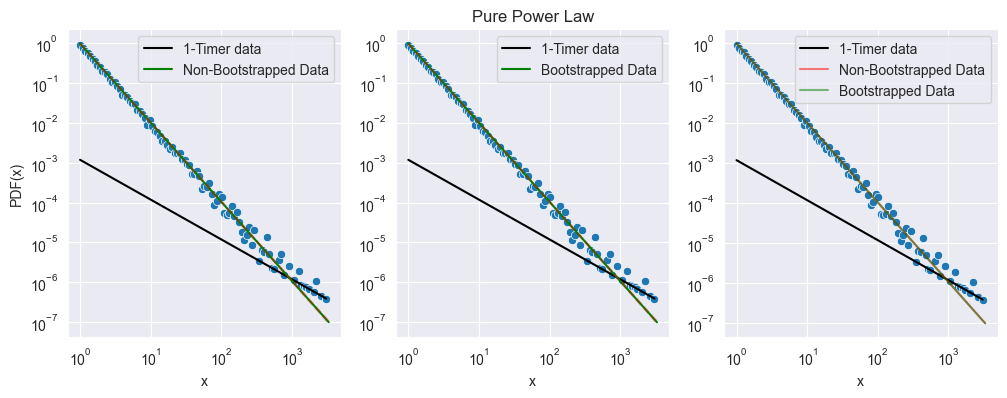

In [12]:
print(f'Non-Bootstrapped Samples:\n\tSlope Predicted: {alpha_pred} +- {alpha_std}')
print(f'\nBootstrapped Samples:\n\tSlope Predicted: {alpha_pred_bootstrap} +- {alpha_std_bootstrap}')

rng.plot_data(x, n_bins, x_estimated, px_bootstrap, px, errors, title='Pure Power Law')

### Power Law with Cutoff Samplework

In [13]:
# Data Generation
print('Generating Samples...')
x = rng.accept_reject_damped(n_samples, alpha=alpha2, x_c=x_c, x_min=x_min)
print('Samples Done!')

Generating Samples...
Generated 10000 in 3 iterations with 2118.64% efficiency
Samples Done!


In [14]:
alpha0, x_c0 = alpha2 + np.random.uniform(-1, 1, 1), x_c + np.random.uniform(-10, 10, 1)

alpha_pred = np.array([])
x_c_pred = np.array([])

cp1 = time.perf_counter()
for _ in range(bootstrap):
    xb = rng.bootstrap_sample(x)
    result = rng.minimize_by_scipy(xb, rng.cutoff_law_likelihood, (alpha0, x_c0))
    alpha_pred = np.append(alpha_pred, result.x[0])
    x_c_pred = np.append(x_c_pred, result.x[1])
cp2 = time.perf_counter()
print(f'Time ellapsed per boostrapped sample: {round(1000*(cp2-cp1)/bootstrap, 3)}ms')
# Alpha
alpha_std_bootstrap = rng.bootstrap_std(alpha_pred, bootstrap)
alpha_pred_bootstrap = np.sum(alpha_pred)/bootstrap
# X_c
x_c_std_bootstrap = rng.bootstrap_std(x_c_pred, bootstrap)
x_c_pred_bootstrap = np.sum(x_c_pred)/bootstrap


x_estimated = np.linspace(min(x), max(x), len(x))
px_bootstrap = rng.damped_power_pdf(x_estimated, alpha=alpha_pred_bootstrap, x_c=x_c_pred_bootstrap, x_min=x_min)

Time ellapsed per boostrapped sample: 70.867ms


In [15]:
# Maximum Likelihood Estimation
result = rng.minimize_by_scipy(x, rng.cutoff_law_likelihood, (alpha0, x_c0))
alpha_pred, x_c_pred = result.x[0], result.x[1]
hess = rng.damped_power_hessian(x, alpha_pred, x_c_pred)
print(hess)
alpha_std, x_c_std = np.diagonal(np.sqrt(np.linalg.inv(hess)))
px = rng.damped_power_pdf(x_estimated, alpha=alpha_pred, x_c=x_c_pred, x_min=x_min)

[[-2.39778492e+05  1.19673213e+03]
 [ 9.84366434e+02 -1.59619929e-01]]


In [16]:
errors_non_bootstrap = []
errors_bootstrap = []
for i in range(4):
    alpha2test = max(1, alpha_pred + (-1)**(i//1)*alpha_std)
    xc2test = max(0, x_c_pred + (-1)**(i//2)*x_c_std)
    errors_non_bootstrap.append(rng.damped_power_pdf(x_estimated, alpha=alpha2test, x_c=xc2test, x_min=x_min))

    alpha2test_b = max(1, alpha_pred_bootstrap + (-1)**(i//1)*alpha_std_bootstrap)
    xc2test_b = max(0, x_c_pred_bootstrap + (-1)**(i//2)*x_c_std_bootstrap)
    errors_bootstrap.append(rng.damped_power_pdf(x_estimated, alpha=alpha2test_b, x_c=xc2test_b, x_min=x_min))

errors_non_bootstrap = np.array([np.max(np.array(errors_non_bootstrap), axis=0), np.min(np.array(errors_non_bootstrap), axis=0)])
errors_bootstrap = np.array([np.max(np.array(errors_bootstrap), axis=0), np.min(np.array(errors_bootstrap), axis=0)])

errors = np.array([errors_non_bootstrap, errors_bootstrap])

Non-Bootstrapped Samples:
	Slope Predicted: 1.987538860985874 +- 0.00037423021604815113
	Damping Factor Predicted: 89.87171375068695 +- 0.45867007423332024

Bootstrapped Samples:
	Slope Predicted: 1.987648541348768 +- 0.019568200115333886
	Damping Factor Predicted: 91.35220232319853 +- 14.171082671180239


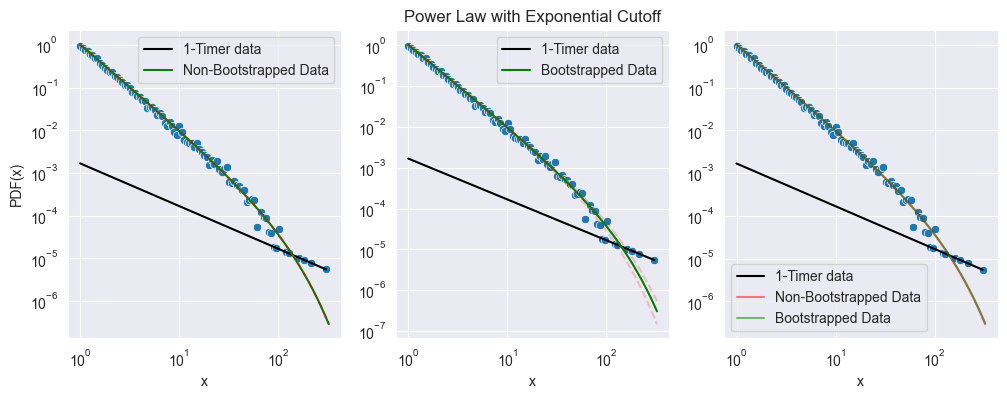

In [17]:
print(f'Non-Bootstrapped Samples:\n\tSlope Predicted: {alpha_pred} +- {alpha_std}\n\tDamping Factor Predicted: {x_c_pred} +- {x_c_std}')
print(f'\nBootstrapped Samples:\n\tSlope Predicted: {alpha_pred_bootstrap} +- {alpha_std_bootstrap}\n\tDamping Factor Predicted: {x_c_pred_bootstrap} +- {x_c_std_bootstrap}')

rng.plot_data(x, n_bins, x_estimated, px_bootstrap, px, errors, title='Power Law with Exponential Cutoff')

### Double Power Law with Cutoff Samplework

In [3]:
# Data Generation
print('Generating Samples...')
x = rng.double_potential_generation(n_samples, alpha1=alpha1, alpha2=alpha2, x_c=x_c, beta=beta, x_min=x_min)
print('Samples Done!')

Generating Samples...
Generated 4946 in 3 iterations with 2178.85% efficiency
Samples Done!


In [4]:
alpha1_0, alpha2_0, x_c0 = alpha1 + np.random.uniform(-1, 1, 1), alpha2 + np.random.uniform(-1, 1, 1), x_c + np.random.uniform(-10, 10, 1)

alpha1_pred = np.array([])
alpha2_pred = np.array([])
x_c_pred = np.array([])

cp1 = time.perf_counter()
for _ in range(bootstrap):
    xb = rng.bootstrap_sample(x)
    result = rng.minimize_by_scipy(xb, rng.dslope_law_likelihood, (alpha1_0, alpha2_0, x_c0))
    alpha1_pred = np.append(alpha1_pred, result.x[0])
    alpha2_pred = np.append(alpha2_pred, result.x[1])
    x_c_pred = np.append(x_c_pred, result.x[2])
cp2 = time.perf_counter()
print(f'Time ellapsed per boostrapped sample: {1000 * round((cp2-cp1)/bootstrap, 3)}ms')

# Alpha1
alpha1_std_bootstrap = rng.bootstrap_std(alpha1_pred, bootstrap)
alpha1_pred_bootstrap = np.sum(alpha1_pred)/bootstrap
# Alpha2
alpha2_std_bootstrap = rng.bootstrap_std(alpha2_pred, bootstrap)
alpha2_pred_bootstrap = np.sum(alpha2_pred)/bootstrap
# X_c
x_c_std_bootstrap = rng.bootstrap_std(x_c_pred, bootstrap)
x_c_pred_bootstrap = np.sum(x_c_pred)/bootstrap

x_estimated = np.linspace(min(x), max(x), len(x))
px_bootstrap, tau_b = rng.dslope_power_pdf(x_estimated, alpha1=alpha1_pred_bootstrap, alpha2=alpha2_pred_bootstrap, x_c=x_c_pred_bootstrap, beta=beta, x_min=x_min)

Time ellapsed per boostrapped sample: 317.0ms


In [5]:
# Maximum Likelihood Estimation
result = rng.minimize_by_scipy(x, rng.dslope_law_likelihood, (alpha1_0, alpha2_0, x_c0))
alpha1_pred, alpha2_pred, x_c_pred = result.x[0], result.x[1], result.x[2]
hess = rng.dslope_power_hessian(x, alpha1_pred, alpha2_pred, x_c_pred)
print(hess)
alpha1_std, alpha2_std, x_c_std = np.diagonal(np.sqrt(abs(np.linalg.inv(hess))))
px, tau = rng.dslope_power_pdf(x_estimated, alpha1=alpha1_pred, alpha2=alpha2_pred, x_c=x_c_pred, beta=beta, x_min=x_min)

[[ 5.66729769e+02  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.32146822e+05  5.50485480e+02]
 [ 0.00000000e+00  4.58206172e+02 -5.44534780e-02]]


In [6]:
errors_non_bootstrap = []
errors_bootstrap = []
for i in range(8):
    alpha12test = max(1.000001, alpha1_pred + (-1)**(i//1)*alpha1_std)
    alpha22test = min(alpha12test, max(1.000001, alpha2_pred + (-1)**(i//2)*alpha2_std))
    xc2test = max(0, x_c_pred + (-1)**(i//4)*x_c_std)
    errors_non_bootstrap.append(rng.dslope_power_pdf(x_estimated, alpha1=alpha12test, alpha2=alpha22test, x_c=xc2test, beta=beta, x_min=x_min)[0])

    alpha12test_b = max(1.000001, alpha1_pred_bootstrap + (-1)**(i//1)*alpha1_std_bootstrap)
    alpha22test_b = min(alpha12test_b, max(1.000001, alpha2_pred_bootstrap + (-1)**(i//2)*alpha2_std_bootstrap))
    xc2test_b = max(0, x_c_pred_bootstrap + (-1)**(i//4)*x_c_std_bootstrap)
    # print(alpha12test_b, alpha22test_b, xc2test_b)
    errors_bootstrap.append(rng.dslope_power_pdf(x_estimated, alpha1=alpha12test_b, alpha2=alpha22test_b, x_c=xc2test_b, beta=beta, x_min=x_min)[0])

errors_non_bootstrap = np.array([np.max(np.array(errors_non_bootstrap), axis=0), np.min(np.array(errors_non_bootstrap), axis=0)])
errors_bootstrap = np.array([np.max(np.array(errors_bootstrap), axis=0), np.min(np.array(errors_bootstrap), axis=0)])

errors = np.array([errors_non_bootstrap, errors_bootstrap])

Akaike Information Criteria: 22506.0487	Bayesian Information Criteria: 22527.6774
Non-Bootstrapped Samples:
	Slope 1 Predicted: 3.9706448014138243 +- 0.042006063768090414
	Slope 2 Predicted: 2.010733732144696 +- 0.00047140515656795006
	Damping Factor Predicted: 102.92868645960249 +- 0.7343614635617629
	Crossing Point Predicted: 64.52995031268065

Bootstrapped Samples:
	Slope 1 Predicted: 3.9670336854166393 +- 0.07425011335571849
	Slope 2 Predicted: 2.011043329078 +- 0.026886870608535864
	Damping Factor Predicted: 104.82263263549254 +- 22.879680574901496
	Crossing Point Predicted: 63.53609586260971


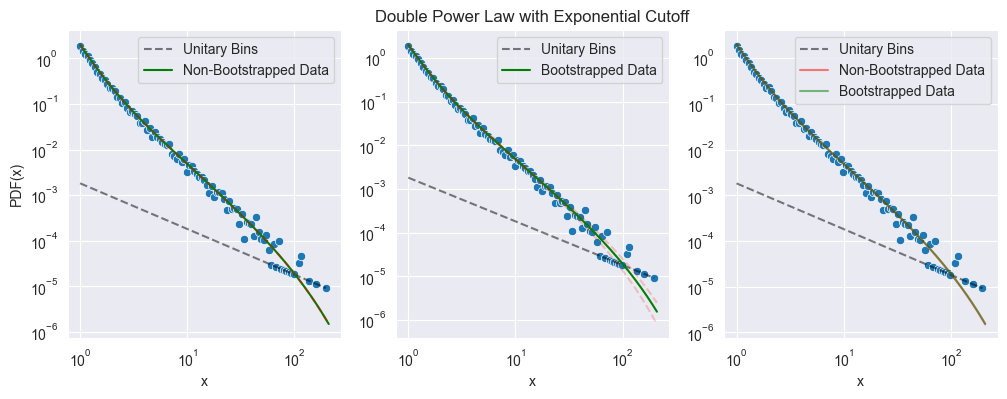

In [7]:
akaike = rng.akaike_information(x, rng.dslope_law_likelihood, (alpha1_pred, alpha2_pred, x_c_pred), x_min=x_min)
bayes = rng.bayesian_information(x, rng.dslope_law_likelihood, (alpha1_pred, alpha2_pred, x_c_pred), x_min=x_min)
print(f'Akaike Information Criteria: {round(akaike, 4)}\tBayesian Information Criteria: {round(bayes, 4)}')

print(f'Non-Bootstrapped Samples:\n\tSlope 1 Predicted: {alpha1_pred} +- {alpha1_std}\n\tSlope 2 Predicted: {alpha2_pred} +- {alpha2_std}\n\tDamping Factor Predicted: {x_c_pred} +- {x_c_std}\n\tCrossing Point Predicted: {tau}')
print(f'\nBootstrapped Samples:\n\tSlope 1 Predicted: {alpha1_pred_bootstrap} +- {alpha1_std_bootstrap}\n\tSlope 2 Predicted: {alpha2_pred_bootstrap} +- {alpha2_std_bootstrap}\n\tDamping Factor Predicted: {x_c_pred_bootstrap} +- {x_c_std_bootstrap}\n\tCrossing Point Predicted: {tau_b}')

rng.plot_data(x, n_bins, x_estimated, px_bootstrap, px, errors, title='Double Power Law with Exponential Cutoff')

### Double Power Law with Cutoff and Unknown Population Distribution Samplework

In [8]:
# Data Generation
print('Generating Samples...')
x = rng.double_potential_generation(n_samples, alpha1=alpha1, alpha2=alpha2, x_c=x_c, beta=beta, x_min=x_min)
print('Samples Done!')

Generating Samples...
Generated 4874 in 3 iterations with 2389.22% efficiency
Samples Done!


In [10]:
alpha1_0, alpha2_0, x_c0, beta0 = alpha1 + np.random.uniform(-1, 1, 1), alpha2 + np.random.uniform(-1, 1, 1), x_c + np.random.uniform(-10, 10, 1), beta + np.random.uniform(-0.3, 0.3, 1)

alpha1_pred = np.array([])
alpha2_pred = np.array([])
x_c_pred = np.array([])
beta_pred = np.array([])

cp1 = time.perf_counter()
for _ in range(bootstrap):
    xb = rng.bootstrap_sample(x)
    result = rng.minimize_by_scipy(xb, rng.dslope_noprob_law_likelihood, (alpha1_0, alpha2_0, x_c0, beta0))
    alpha1_pred = np.append(alpha1_pred, result.x[0])
    alpha2_pred = np.append(alpha2_pred,result.x[1])
    x_c_pred = np.append(x_c_pred,result.x[2])
    beta_pred = np.append(beta_pred,result.x[3])
cp2 = time.perf_counter()
print(f'Time ellapsed per boostrapped sample: {1000 * round((cp2-cp1)/bootstrap, 3)}ms')

# Alpha1
alpha1_std_bootstrap = rng.bootstrap_std(alpha1_pred, bootstrap)
alpha1_pred_bootstrap = np.sum(alpha1_pred)/bootstrap
# Alpha2
alpha2_std_bootstrap = rng.bootstrap_std(alpha2_pred, bootstrap)
alpha2_pred_bootstrap = np.sum(alpha2_pred)/bootstrap
# X_c
x_c_std_bootstrap = rng.bootstrap_std(x_c_pred, bootstrap)
x_c_pred_bootstrap = np.sum(x_c_pred)/bootstrap
# Beta
beta_std_bootstrap = rng.bootstrap_std(beta_pred, bootstrap)
beta_pred_bootstrap = np.sum(beta_pred)/bootstrap

x_estimated = np.linspace(min(x), max(x), n_samples)
px_bootstrap, tau_b = rng.dslope_power_pdf(x_estimated, alpha1=alpha1_pred_bootstrap, alpha2=alpha2_pred_bootstrap, x_c=x_c_pred_bootstrap, beta=beta_pred_bootstrap, x_min=x_min)

Time ellapsed per boostrapped sample: 536.0ms


In [11]:
# Maximum Likelihood Estimation
result = rng.minimize_by_scipy(x, rng.dslope_noprob_law_likelihood, (alpha1_0, alpha2_0, x_c0, beta0))
alpha1_pred, alpha2_pred, x_c_pred, beta_pred = result.x[0], result.x[1], result.x[2], result.x[3]
hess = rng.dslope_power_no_prob_hessian(x, alpha1_pred, alpha2_pred, x_c_pred, beta_pred)
print(hess) # WIP
alpha1_std, alpha2_std, x_c_std, beta_std = np.diagonal(np.sqrt(np.linalg.inv(hess)))
px, tau = rng.dslope_power_pdf(x_estimated, alpha1=alpha1_pred, alpha2=alpha2_pred, x_c=x_c_pred, beta=beta_pred, x_min=x_min)

[[ 6.12393481e+02  0.00000000e+00  0.00000000e+00 -5.89974356e-05]
 [ 0.00000000e+00 -1.34610498e+05  4.80366224e+02 -9.83556529e+04]
 [ 0.00000000e+00  4.01097588e+02 -3.93028501e-02  5.73917604e+00]
 [-3.07657680e-05 -4.70655051e+04  2.74633142e+00  1.00000000e+00]]


In [12]:
errors_non_bootstrap = []
errors_bootstrap = []
for i in range(16):
    alpha12test = max(1, alpha1_pred + (-1)**(i//1)*alpha1_std)
    alpha22test = min(alpha12test, max(1, alpha2_pred + (-1)**(i//2)*alpha2_std))
    xc2test = max(0, x_c_pred + (-1)**(i//4)*x_c_std)
    beta2test = min(1, max(0, beta_pred + (-1)**(i//8)*beta_std))
    errors_non_bootstrap.append(rng.dslope_power_pdf(x_estimated, alpha1=alpha12test, alpha2=alpha22test, x_c=xc2test, beta=beta2test, x_min=x_min)[0])

    alpha12test_b = max(1, alpha1_pred_bootstrap + (-1)**(i//1)*alpha1_std_bootstrap)
    alpha22test_b = min(alpha12test_b, max(1, alpha2_pred_bootstrap + (-1)**(i//2)*alpha2_std_bootstrap))
    xc2test_b = max(0, x_c_pred_bootstrap + (-1)**(i//4)*x_c_std_bootstrap)
    beta2test_b = min(1, max(0, beta_pred_bootstrap + (-1)**(i//8)*beta_std_bootstrap))
    errors_bootstrap.append(rng.dslope_power_pdf(x_estimated, alpha1=alpha12test_b, alpha2=alpha22test_b, x_c=xc2test_b, beta=beta2test_b, x_min=x_min)[0])

errors_non_bootstrap = np.array([np.max(np.array(errors_non_bootstrap), axis=0), np.min(np.array(errors_non_bootstrap), axis=0)])
errors_bootstrap = np.array([np.max(np.array(errors_bootstrap), axis=0), np.min(np.array(errors_bootstrap), axis=0)])

errors = np.array([errors_non_bootstrap, errors_bootstrap])

Akaike Information Criteria: 22254.3103	Bayesian Information Criteria: 22283.1477
Non-Bootstrapped Samples:
	Slope 1 Predicted: 3.9181125108751336 +- 0.04040961571270984
	Slope 2 Predicted: 2.006679472055481 +- 0.0005398110267805003
	Damping Factor Predicted: 115.23175721695577 +- 9.23968248483937
	Probability Predicted: 0.521476358976175 +- 0.058784791831431954
	Crossing Point Predicted: 41.798527059534905

Bootstrapped Samples:
	Slope 1 Predicted: 3.968701878082233 +- 0.2760557594755576
	Slope 2 Predicted: 2.0119387262453854 +- 0.11458050212103486
	Damping Factor Predicted: 129.11363300813002 +- 51.32810535649185
	Probability Predicted: 0.5132636890682757 +- 0.07904810591609487
	Crossing Point Predicted: 71.25898267655211


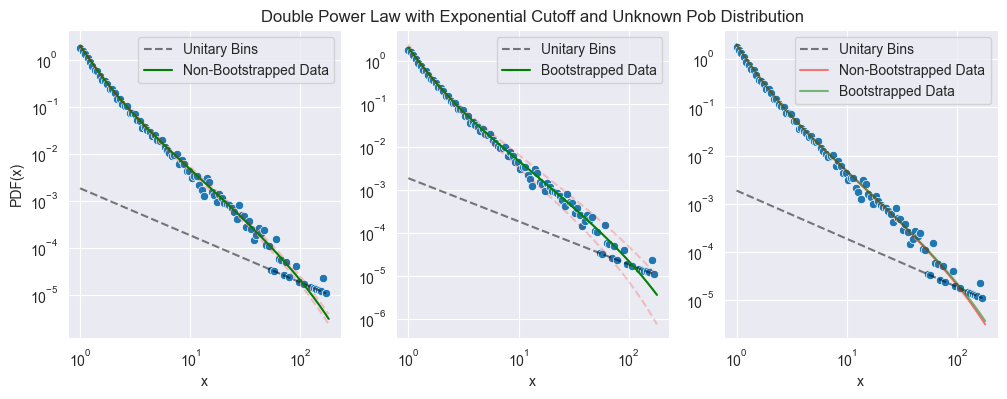

In [13]:
akaike = rng.akaike_information(x, rng.dslope_noprob_law_likelihood, (alpha1_pred, alpha2_pred, x_c_pred, beta_pred), x_min=x_min)
bayes = rng.bayesian_information(x, rng.dslope_noprob_law_likelihood, (alpha1_pred, alpha2_pred, x_c_pred, beta_pred), x_min=x_min)

print(f'Akaike Information Criteria: {round(akaike, 4)}\tBayesian Information Criteria: {round(bayes, 4)}')

print(f'Non-Bootstrapped Samples:\n\tSlope 1 Predicted: {alpha1_pred} +- {alpha1_std}\n\tSlope 2 Predicted: {alpha2_pred} +- {alpha2_std}\n\tDamping Factor Predicted: {x_c_pred} +- {x_c_std}\n\tProbability Predicted: {beta_pred} +- {beta_std}\n\tCrossing Point Predicted: {tau}')
print(f'\nBootstrapped Samples:\n\tSlope 1 Predicted: {alpha1_pred_bootstrap} +- {alpha1_std_bootstrap}\n\tSlope 2 Predicted: {alpha2_pred_bootstrap} +- {alpha2_std_bootstrap}\n\tDamping Factor Predicted: {x_c_pred_bootstrap} +- {x_c_std_bootstrap}\n\tProbability Predicted: {beta_pred_bootstrap} +- {beta_std_bootstrap}\n\tCrossing Point Predicted: {tau_b}')
        
rng.plot_data(x, n_bins, x_estimated, px_bootstrap, px, errors, title='Double Power Law with Exponential Cutoff and Unknown Pob Distribution')

## Real Data Analysis

### Data 1

In [14]:
data1 = pd.read_csv('data/c1/simBondPercAllp0.40hL256_lat_c1.dat', sep='\t', header=None)
x1 = data1[data1[0] >= 8][0].to_numpy() 
x1 = x1 / min(x1)
len(x1)

205493

Time ellapsed to Compute the Hessian: 0.003ms
Akaike Information Criteria: 598723.9883	Bayesian Information Criteria: 598734.2214

Non-Bootstrapped Samples:
	Slope Predicted: 2.3375514541512645 +- 0.0029506111662227132

Bootstrapped Samples:
	Slope Predicted: 2.3375315113601713 +- 0.0026347890883189205


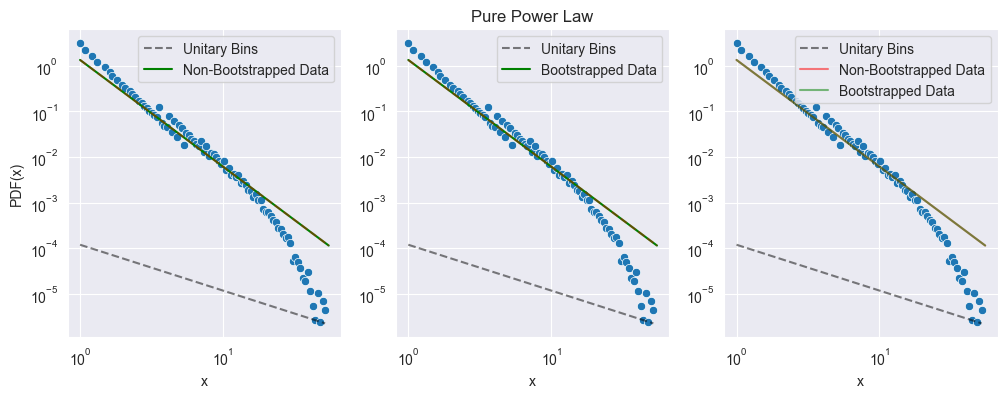

2.3375514541512645

In [15]:
rng.generate_power_law_sample(x=x1, alpha=2, x_min=1, show_data=True, n_bins=n_bins, bootstrap=bootstrap)

Time ellapsed to Compute the Hessian: 2378.827ms
Akaike Information Criteria: 594388.3431	Bayesian Information Criteria: 594408.8094

Non-Bootstrapped Samples:
	Slope Predicted: 2.0242211866160478 +- 0.00019488713411877268
	Damping Factor Predicted: 16.92111520441936 +- 0.016267072323906447

Bootstrapped Samples:
	Slope Predicted: 2.0237319645744707 +- 0.007600718791635771
	Damping Factor Predicted: 16.428443573209677 +- 2.9206349544084067


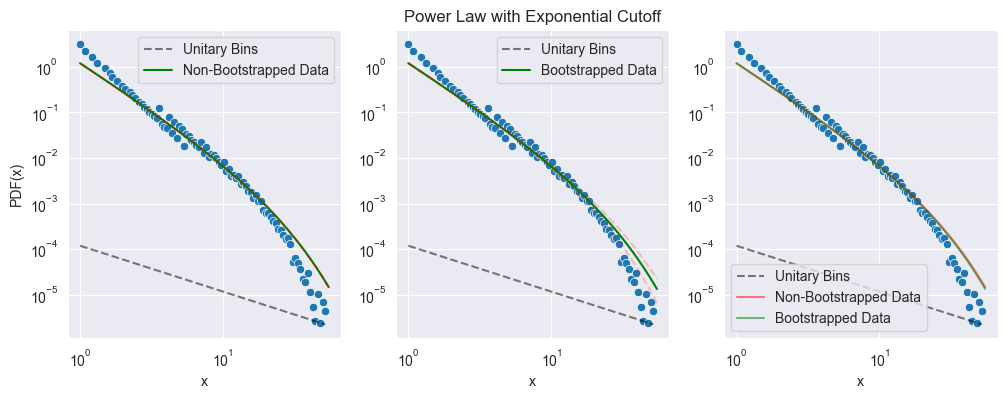

(2.0242211866160478, 16.92111520441936)

In [17]:
rng.generate_cutoff_law_sample(x=x1, alpha=2.2, x_c=16, x_min=1, show_data=True, n_bins=n_bins, bootstrap=bootstrap)

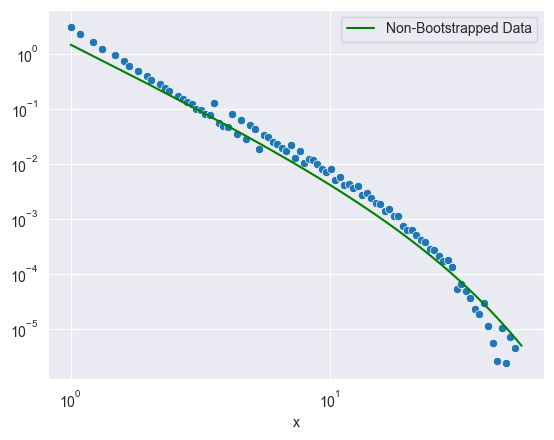

In [25]:
plt.yscale('log')
plt.xscale('log')
hist, bin_edges = np.histogram(np.log10(x1), bins=n_bins)
bin_width = [np.power(10, bin_edges[i + 1]) - np.power(10, bin_edges[i]) for i in range(len(bin_edges) - 1)]
t_hist = hist.sum()
hist = hist/bin_width / t_hist
x_hist = [np.log10(np.min(x1)) + np.log10(np.max(x1) - np.min(x1))*(i) / n_bins for i in range(len(hist))]
y_base = np.ones(len(x_hist))/bin_width / t_hist
x_estimated = np.linspace(np.floor(min(x1)), np.ceil(max(x1)), int(np.ceil(max(x1)) - np.floor(min(x1))))
px = rng.damped_power_pdf(x=x_estimated, alpha=2.3, x_c=16, x_min=1)
sns.scatterplot(x=np.power(10, x_hist), y=hist)
sns.lineplot(x=x_estimated, y=px, color='green', label='Non-Bootstrapped Data')
plt.xlabel("x")

plt.legend()
plt.show()

Time ellapsed to Compute the Hessian: 2363.758ms
Akaike Information Criteria: 589629.257	Bayesian Information Criteria: 589659.9564

Non-Bootstrapped Samples:
	Slope 1 Predicted: 3.598261409403836 +- 0.00814116408862986
	Slope 2 Predicted: 0.6287079010814054 +- 0.009088969068810456
	Damping Factor Predicted: 4.716420012264901 +- 0.035711144138623904
	Crossing Point Predicted: 1.6823928949342606

Bootstrapped Samples:
	Slope 1 Predicted: 3.6009568363981073 +- 0.003902562169097462
	Slope 2 Predicted: 0.6372742243862779 +- 0.013314829863496816
	Damping Factor Predicted: 4.743276855135039 +- 0.01956807708119967
	Crossing Point Predicted: 1.6952476947499517


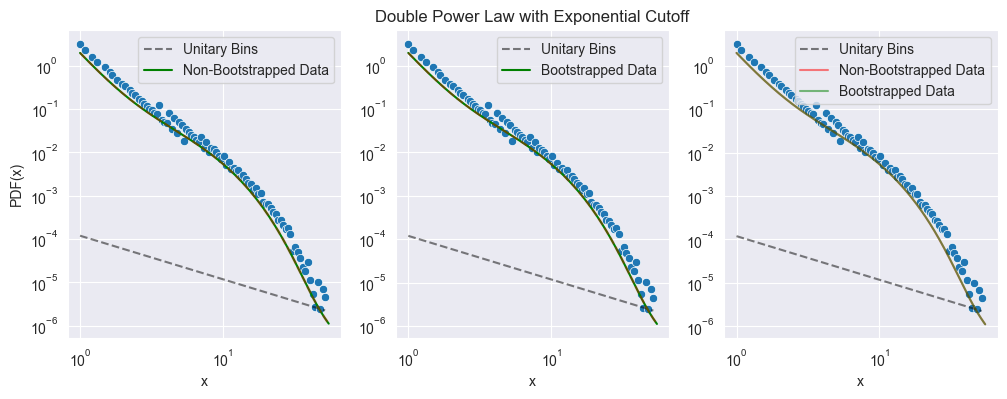

(3.598261409403836, 0.6287079010814054, 4.716420012264901)

In [21]:
rng.generate_dslope_law_sample(x=x1, alpha1=3.5, alpha2=0.6, x_c=4, beta=0.7, x_min=x_min, show_data=True, n_bins=n_bins, bootstrap=2)

In [4]:
rng.generate_dslope_noprob_law_sample(x=x1, alpha1=alpha1, alpha2=alpha2, x_c=x_c, beta=beta, x_min=x_min, show_data=True, n_bins=n_bins, bootstrap=2)

3.165648365132844 1.7170072544104709 95.80990397088104 0.49784686399752254
3.165648380034005 1.7170072544104709 95.80990397088104 0.49784686399752254
3.165648365132844 1.717007269311632 95.80990397088104 0.49784686399752254
3.165648365132844 1.7170072544104709 95.8099039857822 0.49784686399752254
3.165648365132844 1.7170072544104709 95.80990397088104 0.49784687889868373
2.000055997737169 1.9996613583571683 66.68490397088104 0.9999767848608762
2.8339833253456117 1.797435444619855 87.52249187553055 0.6407260941983928
2.833983340246773 1.797435444619855 87.52249187553055 0.6407260941983928
2.8339833253456117 1.7974354595210162 87.52249187553055 0.6407260941983928
2.8339833253456117 1.797435444619855 87.52249189043171 0.6407260941983928
2.8339833253456117 1.797435444619855 87.52249187553055 0.640726109099554
2.0018266759941694 1.9997904005913918 0.040879478061143004 0.42342416457768867
2.7507676604104674 1.8176709402170088 78.77433063578361 0.6189959012363223
2.7507676753116286 1.817670940

ZeroDivisionError: division by zero

### Data 2

In [3]:
data2 = pd.read_csv('data/c2/13_23_bzr_events_c2.dat', sep='\s', header=None)
x2 = data2[1].to_numpy()
len(x2)

5013

Time ellapsed to Compute the Hessian: 0.0ms
Non-Bootstrapped Samples:
	Slope Predicted: 1.3383016081985804 +- 0.004778099727478932

Bootstrapped Samples:
	Slope Predicted: 1.3382994291213006 +- 0.004168281202103517


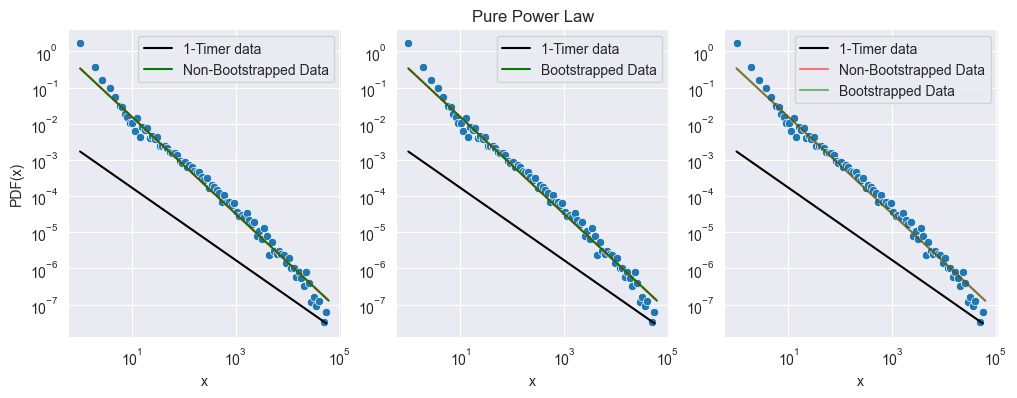

1.3383016081985804

In [12]:
rng.generate_power_law_sample(x=x2, alpha=alpha2, x_min=x_min, show_data=True, n_bins=n_bins, bootstrap=bootstrap)

Time ellapsed to Compute the Hessian: 59.0ms
Non-Bootstrapped Samples:
	Slope Predicted: 1.263638501055056 +- 0.0009021617312816887
	Damping Factor Predicted: 27105.447633858694 +- 640.1860365407784

Bootstrapped Samples:
	Slope Predicted: 1.264131064477163 +- 0.00627678947595705
	Damping Factor Predicted: 27296.7258350746 +- 3026.2582528737644


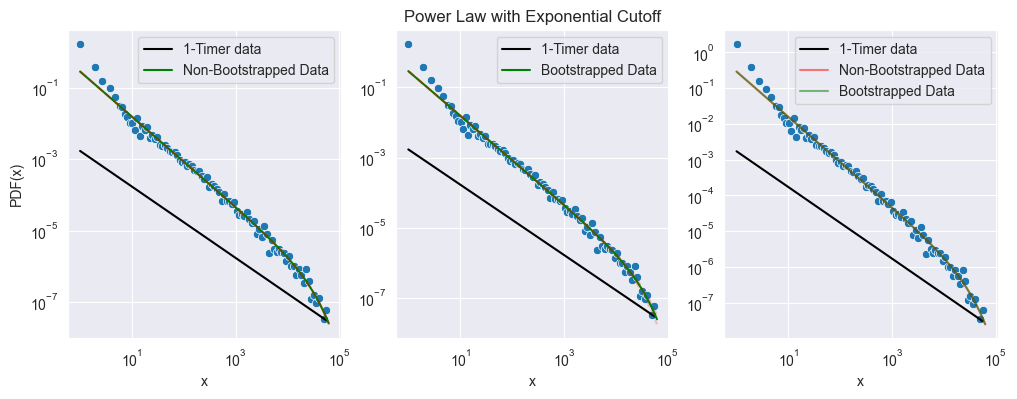

(1.263638501055056, 27105.447633858694)

In [13]:
rng.generate_cutoff_law_sample(x=x2, alpha=alpha2, x_c=x_c, x_min=x_min, show_data=True, n_bins=n_bins, bootstrap=bootstrap)

Time ellapsed to Compute the Hessian: 11282.0ms
Non-Bootstrapped Samples:
	Slope 1 Predicted: 1.690393134241833 +- 0.01399493710314345
	Slope 2 Predicted: 1.0094132064997092 +- 0.010172252771789358
	Damping Factor Predicted: 10687.183980881298 +- 914.8367663372502
	Crossing Point Predicted: 16.95367853323936

Bootstrapped Samples:
	Slope 1 Predicted: 1.6457236816494936 +- 0.04568156267319947
	Slope 2 Predicted: 1.0124951601049101 +- 0.020780375983945738
	Damping Factor Predicted: 9317.737293012224 +- 782.8330435375321
	Crossing Point Predicted: 19.6675499216929


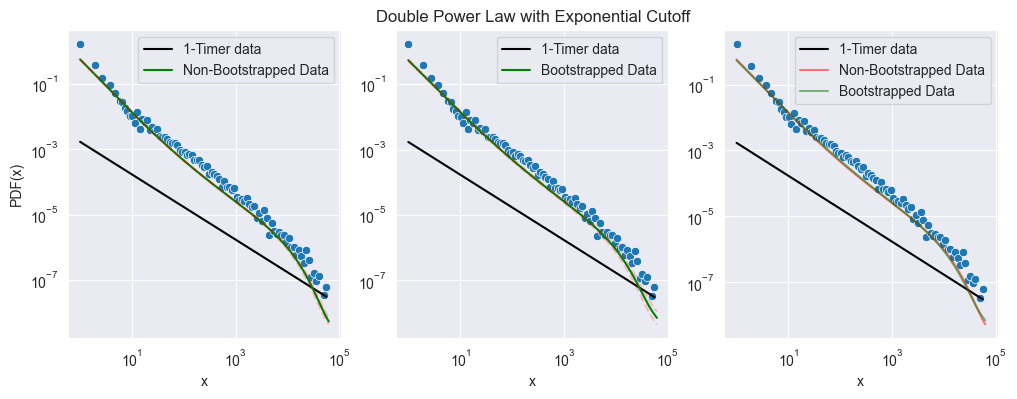

(1.690393134241833, 1.0094132064997092, 10687.183980881298)

In [4]:
rng.generate_dslope_law_sample(x=x2, alpha1=alpha1, alpha2=alpha2, x_c=x_c, beta=0.8, x_min=x_min, show_data=True, n_bins=n_bins, bootstrap=2)

In [15]:
rng.generate_dslope_noprob_law_sample(x=x2, alpha1=alpha1, alpha2=alpha2, x_c=x_c, beta=0.8, x_min=x_min, show_data=True, n_bins=n_bins, bootstrap=bootstrap)

TypeError: Cannot convert complex to float

### Data 3

In [5]:
data3 = pd.read_csv('data/c8/simELFBM-W-a1.50h0.00L256_it50.Seq', sep='\s+', header=None)
x3 = data3[7].to_numpy()
len(x3)

150463

Time ellapsed to Compute the Hessian: 0.0ms
Non-Bootstrapped Samples:
	Slope Predicted: 4.260865645466187 +- 0.008406554772812286

Bootstrapped Samples:
	Slope Predicted: 4.26184903099092 +- 0.017662417228224203


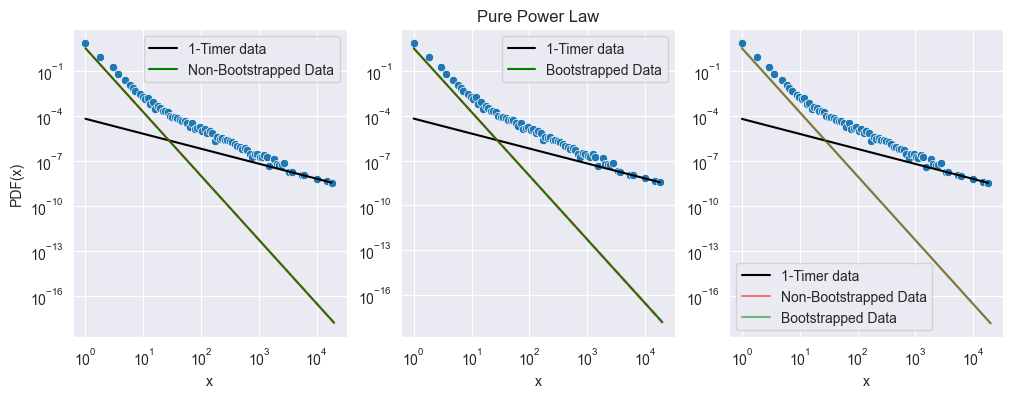

4.260865645466187

In [17]:
rng.generate_power_law_sample(x=x3, alpha=alpha2, x_min=x_min, show_data=True, n_bins=n_bins, bootstrap=bootstrap)

Non-Bootstrapped Samples:
	Slope Predicted: 4.260865649266474 +- 7.767003351266588e-13
	Damping Factor Predicted: 231503454438457.44 +- 105469965753.02344

Bootstrapped Samples:
	Slope Predicted: 4.261110911725657 +- 0.017068924190081
	Damping Factor Predicted: 1004140217768268.6 +- 872067120695841.8


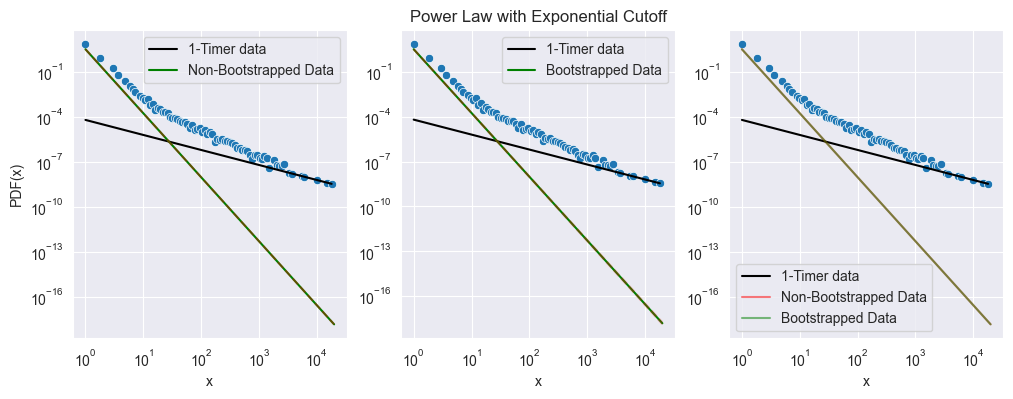

(4.260865649266474, 231503454438457.44)

In [ ]:
rng.generate_cutoff_law_sample(x=x3, alpha=alpha2, x_c=x_c, x_min=x_min, show_data=True, n_bins=n_bins, bootstrap=bootstrap)

In [ ]:
rng.generate_dslope_law_sample(x=x3, alpha1=alpha1, alpha2=alpha2, x_c=x_c, beta=beta, x_min=x_min, show_data=True, n_bins=n_bins, bootstrap=bootstrap)

TypeError: Cannot convert complex to float

In [ ]:
rng.generate_dslope_noprob_law_sample(x=x3, alpha1=alpha1, alpha2=alpha2, x_c=x_c, beta=0.8, x_min=x_min, show_data=True, n_bins=n_bins, bootstrap=bootstrap)

In [44]:
min(x3)

1

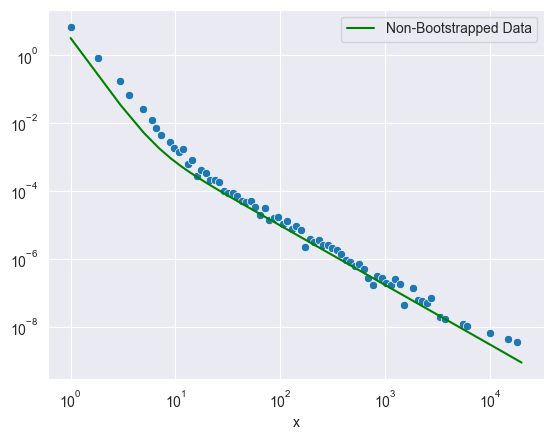

In [18]:
plt.yscale('log')
plt.xscale('log')
hist, bin_edges = np.histogram(np.log10(x3), bins=n_bins)
bin_width = [np.power(10, bin_edges[i + 1]) - np.power(10, bin_edges[i]) for i in range(len(bin_edges) - 1)]
t_hist = hist.sum()
hist = hist/bin_width / t_hist
x_hist = [np.log10(np.min(x3)) + np.log10(np.max(x3) - np.min(x3))*(i) / n_bins for i in range(len(hist))]
y_base = np.ones(len(x_hist))/bin_width / t_hist
x_estimated = np.linspace(min(x3), max(x3), n_samples)
px, tau = rng.dslope_power_pdf(x=x_estimated, alpha1=4.26, alpha2=1.75, x_c=1000000, beta=0.96, x_min=1)
sns.scatterplot(x=np.power(10, x_hist), y=hist)
sns.lineplot(x=x_estimated, y=px, color='green', label='Non-Bootstrapped Data')
plt.xlabel("x")

plt.legend()
plt.show()